### Notebook to fetch submission metadata and display ome_ngff images from BioImage Archive using BIA API

In [53]:
import requests
import urllib3
import zarr

In [54]:
urllib3.disable_warnings()

In [55]:
api_base_url = 'https://45.88.81.209:8080'

In [56]:
def get_study_uuid_by_accession(accno):
    acc_url= api_base_url + '/api/v1/object_info_by_accessions'
    accessions = [accno]
    param = {'accessions': accessions}
    response = requests.get(acc_url, param, verify=False)
    if response.status_code == 200:
        study_uuid = response.json()[0]['uuid']
        return study_uuid
    else:
        print(response.status_code)
        return None

In [72]:
def print_study_info(study_uuid):
    endpoint = f'/api/v1/studies/{study_uuid}'
    response = requests.get(api_base_url+endpoint,verify=False)
    info_items = ['title','organism','imaging_type']
    if response.status_code == 200:
        data = response.json()
        print('accession_id: ',data['accession_id'])
        for k,v in data.items():
            if k in info_items:
                print(k,': ',v)

In [73]:
acc_no = 'S-BIAD634'
study_uuid = get_study_uuid_by_accession(acc_no)
print_study_info(study_uuid)

accession_id:  S-BIAD634
title :  An annotated fluorescence image dataset for training nuclear segmentation methods
organism :  Homo sapiens
imaging_type :  confocal fluorescence microscopy


In [74]:
def get_ome_ngff_uris_by_study_uuid(study_uuid):
    endpoint = f'/api/v1/studies/{study_uuid}/images'
    get_images_url = api_base_url + endpoint
    response = requests.get(get_images_url, verify=False)
    ome_ngff_uris = {}
    if response.status_code == 200:
        data = response.json()
        for image in data:
            image_uuid = image['uuid']
            for rep in image['representations']:
                if rep['type'] == 'ome_ngff':
                    image_uri = rep['uri']
                    ome_ngff_uris[image_uuid] = image_uri
    return ome_ngff_uris

In [75]:
ome_ngff_uris = get_ome_ngff_uris_by_study_uuid(study_uuid)

In [76]:
import dask.array as da

def load_ome_zarr_from_uri(uri):
    zgroup = zarr.open(uri)
    zarray = zgroup['0']    

    darray = da.from_zarr(zarray)
    return darray

In [77]:
img2_uri = list(ome_ngff_uris.values())[1][0]
lazy_img = load_ome_zarr_from_uri(img2_uri)
lazy_img

dask.array<from-zarr, shape=(1, 1, 1, 1024, 1360), dtype=uint8, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

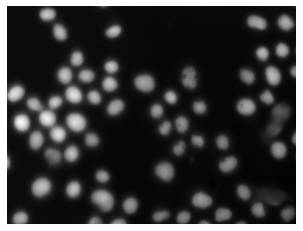

In [66]:
import matplotlib.pyplot as plt

selected_slice = lazy_img[0,0,0].compute()

plt.imshow(selected_slice, cmap='gray')
plt.axis('off')
plt.show()